# Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib.pyplot import imread
import cv2
from PIL import Image
import time
import os
import sys

# Import Modules from Source Code

In [2]:
sys.path.append("../")

In [3]:
from src.ImageCompressor import image_functions as img_func
from src.SVD import two_phase_svd

# Compare Performance of 2-Phase SVDs

In [4]:
Test_Matrix = np.random.rand(300, 300)
start = time.time()
s, v, d = two_phase_svd.svd_phase_A(Test_Matrix)
end = time.time()
print("Time for Phase IIA =", end - start)

start = time.time()
s, v, d = two_phase_svd.svd_phase_B(Test_Matrix)
end = time.time()
print("Time for Phase IIB =", end - start)

Total Iterations: 723
Time for Phase IIA = 2.835116147994995
Total Iterations: 305
Time for Phase IIB = 2.019378900527954


# SVD for Deblurring Images

In [5]:
tik = time.time()

## Built Imaging Functions

In [33]:
def process_and_plot_image(image_path):
    """Process and plot image as input"""
    if image_path[-3:] == "png":
        img = imread(image_path)
    else:
        img = Image.open(image_path)
        img = np.asarray(img)

    img = img_func.img2double(img)
    img_gray = np.mean(img, -1)

    n_rows, n_cols = img_gray.shape

    print(f'original image: {img.shape}')
    print(f'grayscaled image: {img_gray.shape}')

    fig = plt.figure(0, (12, 6))
    for idx, im in enumerate([img, img_gray]):
        ax = plt.subplot(1, 2, idx+1)
        if len(im.shape) == 2:
            ax.imshow(im, cmap='gray')
        else:
            ax.imshow(im)

    return img, img_gray # Output original and grayscale image


def plot_grayscale_images(U: np.ndarray, S: np.ndarray, VT: np.ndarray, img_gray: np.ndarray, ranks: list = [5, 25, 50, 100, 250]):
    """Function to plot the images for different ranks and the original image"""
    fig = plt.figure(0, (18, 12))
    fig.subplots_adjust(top=1.1)

    for idx, r in enumerate(ranks):
        X_r = U[:, :r] @ S[:r, :r] @ VT[:r, :]

        ax = plt.subplot(2, 3, idx+1)
        ax.imshow(X_r, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

        ax.set_title(f'''rank {r}\nfrobenious_norm: {round(img_func.frobenious_norm(img_gray, X_r), 2)}''')
        
    ax = plt.subplot(2, 3, idx+2)
    ax.imshow(img_gray, cmap='gray')
    ax.set_title('original image')
    plt.show()
    
    
def plot_rank_v_sigma_and_frobenious_norm(U: np.ndarray, S: np.ndarray, VT: np.ndarray, img_gray: np.ndarray):
    """Function to plot the graphs for rank versus log sigma and rank versus frobenious norm"""
    fig = plt.figure(0, (12, 6))
    fig.subplots_adjust(top=1.7, right=1.)

    ax1 = plt.subplot(2, 2, 1)
    ax1.semilogy(np.diag(S))
    ax1.set_xlabel('rank')
    ax1.set_ylabel('log sigma')
    ax1.set_title('rank   v/s   log_sigma')

    frob_norm = []
    x_ticks = []
    rank = np.linalg.matrix_rank(img_gray)
    for r in np.linspace(1, rank, 100):
        r = int(r)
        x_ticks.append(r)

        X_r = U[:, :r] @ S[:r, :r] @ VT[:r, :]

        frob_norm.append(img_func.frobenious_norm(img_gray, X_r))

    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(x_ticks, frob_norm)
    ax2.set_xlabel('rank')
    ax2.set_ylabel('frobenious_norm')
    ax2.set_title('rank   v/s   frobenious_norm')
    plt.show()


def plot_truncate_svd(img_gray, S):
    """Function to plot the graphs for truncation versus log sigma for different truncation values"""
    figure, axis = plt.subplots(2, 3, figsize=(15, 15))

    # Use enumerate to get both the index and the value of trunc_values
    trunc_values = [5, 25, 50, 100, 250]
    for idx, trunc_value in enumerate(trunc_values):
        i = idx // 3
        j = idx % 3
        axis[i, j].semilogy(img_func.truncate_svd(img_gray, 6, trunc_value, trunc_value)[2])
        axis[i, j].set_title('trunc v/s log_sigma for trunc_value = {}'.format(trunc_value))

    axis[1, 2].semilogy(np.diag(S))
    axis[1, 2].set_title('trunc v/s log_sigma')
    plt.show()

    
def plot_psnr_values(img_gray: np.ndarray):
    """Function to plot the graphs for PSNR values versus truncation values """
    psnr_vals = []
    trunc_values = [5, 25, 50, 100, 250]

    for idx, r in enumerate(trunc_values):
        psnr_vals.append(img_func.truncate_svd(img_gray, 6, r, r)[1])

    plt.plot(trunc_values, psnr_vals,marker='o')
    plt.title("PSNR Values Plot")
    plt.xlabel("Trunc values")
    plt.ylabel("PSNR Values")
    plt.xticks(trunc_values, rotation ='vertical')
    plt.show()

    
def plot_image_channels(img: np.ndarray):
    """Function to plot the image channels for given truncation values"""
    trunc_vals = [5, 25, 50, 100, 250]
    red_channel, green_channel, blue_channel =  img[:, :, 0], img[:, :, 1], img[:, :, 2]

    fig = plt.figure(0, (18, 12))
    fig.subplots_adjust(top=1.1)

    for idx, r in enumerate(trunc_vals):
        XR_r = img_func.truncate_svd(red_channel, 6, r, r)[0]
        XG_r = img_func.truncate_svd(green_channel, 6, r, r)[0]
        XB_r = img_func.truncate_svd(blue_channel, 6, r, r)[0]
        X_r = np.dstack((XR_r, XG_r, XB_r))
        ax = plt.subplot(2, 3, idx+1)
        ax.imshow(X_r)
        ax.set_xticks([])
        ax.set_yticks([]) 
        ax.set_title(f'''Trunc: {r}\n''')

    ax = plt.subplot(2, 3, idx+2)
    ax.imshow(img)
    ax.set_title('original image')
    ax.set_xticks([])
    ax.set_yticks([])

## Image #1: 512_512_buildings.png

In [ ]:
IMAGE_PATH = "https://raw.githubusercontent.com/dharmazz/SVD-Project/main/test_images/512_512_buildings.png"
img, img_gray = process_and_plot_image(IMAGE_PATH)

In [8]:
np.linalg.matrix_rank(img_gray)

512

In [9]:
%%time

max_norm=30
opt_rank_by_norm = img_func.get_optimal_rank(img_gray, by='norm', max_norm=max_norm)
print(f'optimum rank for frob_norm={max_norm} is {opt_rank_by_norm}')

optimum rank for frob_norm=30 is 9
Wall time: 137 ms


In [10]:
%%time

U, S, VT = img_func.numpy_svd(img_gray)
print(f'U: {U.shape}, S: {(S).shape}, VT: {VT.shape}')

U: (512, 512), S: (512, 512), VT: (512, 512)
Wall time: 110 ms


In [11]:
# Calculate Relative Error
Ub, Sb, VTb = img_func.phase_B_svd(img_gray)
Ua, Sa, VTa = img_func.phase_A_svd(img_gray)
Un, Sn, VTn = img_func.numpy_svd(img_gray)
print("Relative error of Phase A as compare to numpy's: ", img_func.relative_error(Sn,Sa))
print("Relative error of Phase B as compare to numpy's: ", img_func.relative_error(Sn,Sb))

Total Iterations: 517
Total Iterations: 1061
Relative error of Phase A as compare to numpy's:  7.412775950506935e-16
Relative error of Phase B as compare to numpy's:  0.0001142274732921665


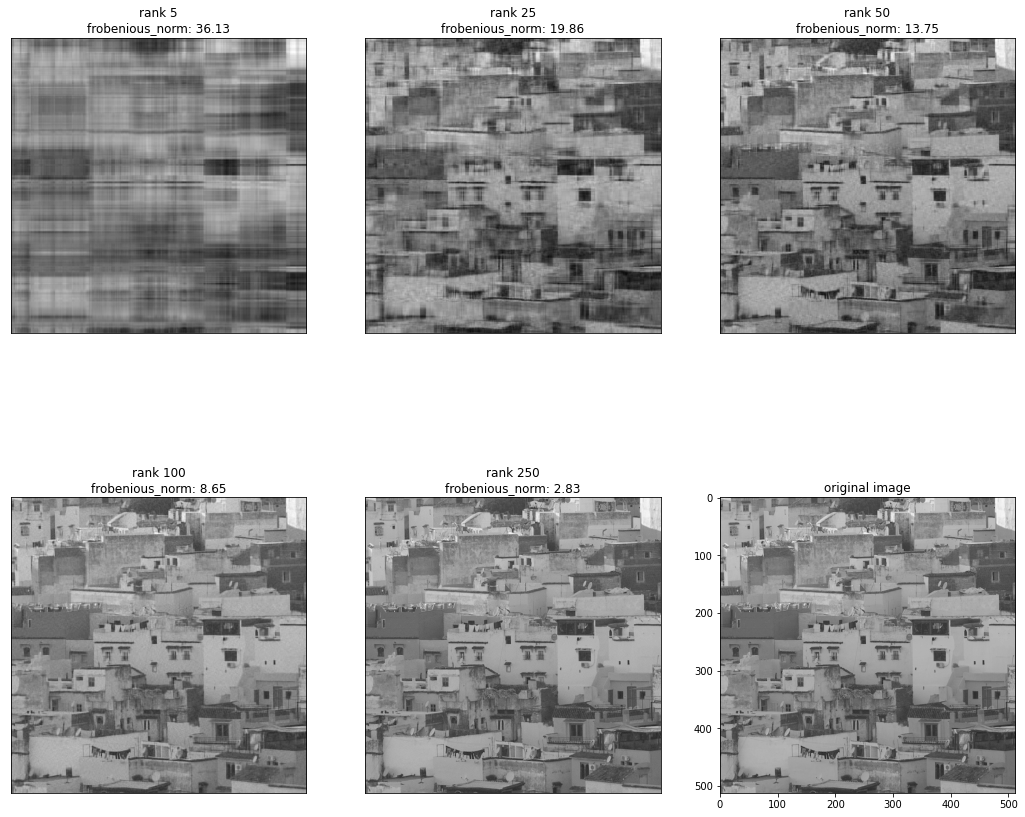

Wall time: 610 ms


In [12]:
%%time

plot_grayscale_images(U, S, VT, img_gray)

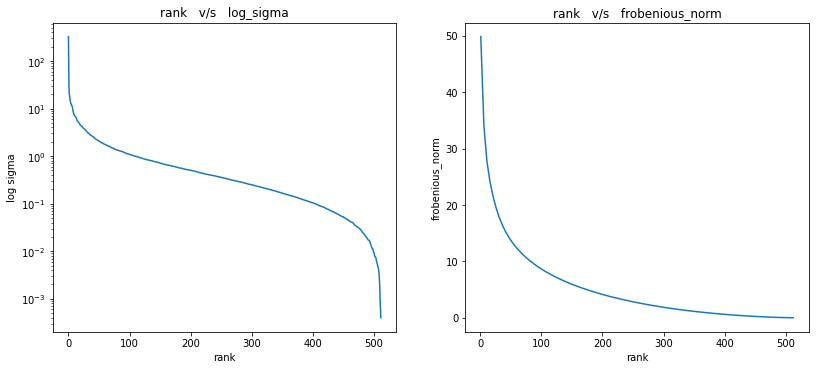

Wall time: 1.07 s


In [13]:
%%time

plot_rank_v_sigma_and_frobenious_norm(U, S, VT, img_gray)

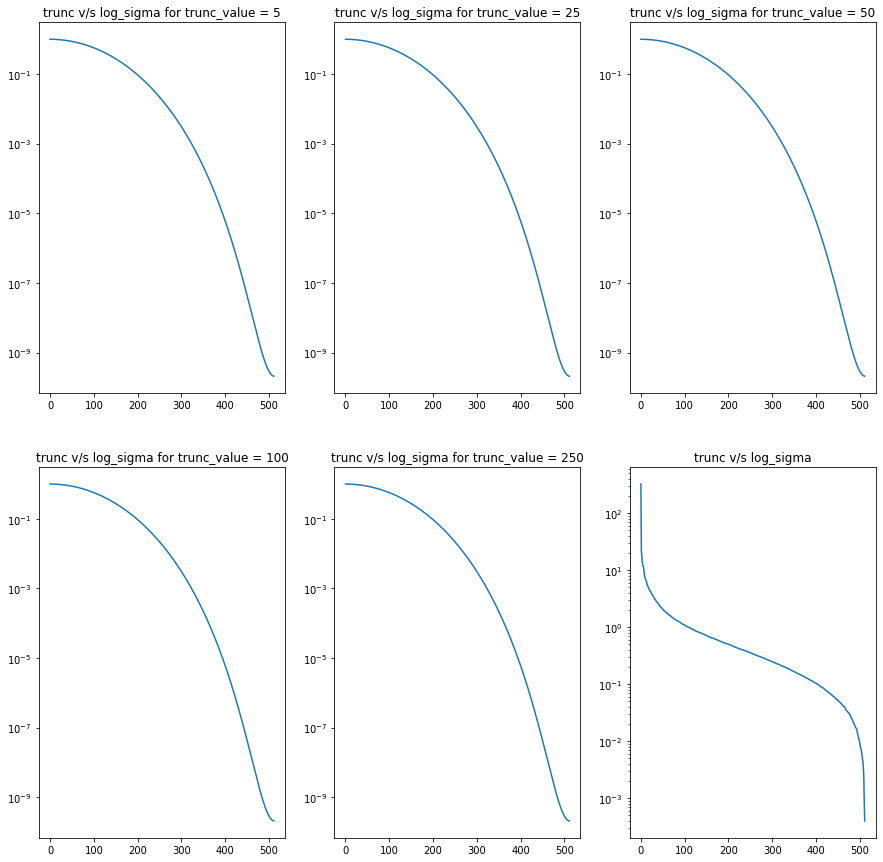

Wall time: 3.28 s


In [14]:
%%time

plot_truncate_svd(img_gray, S)

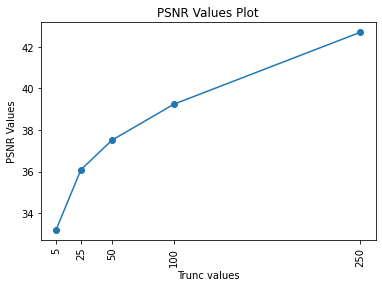

Wall time: 3.02 s


In [15]:
%%time

plot_psnr_values(img_gray)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Wall time: 19.4 s


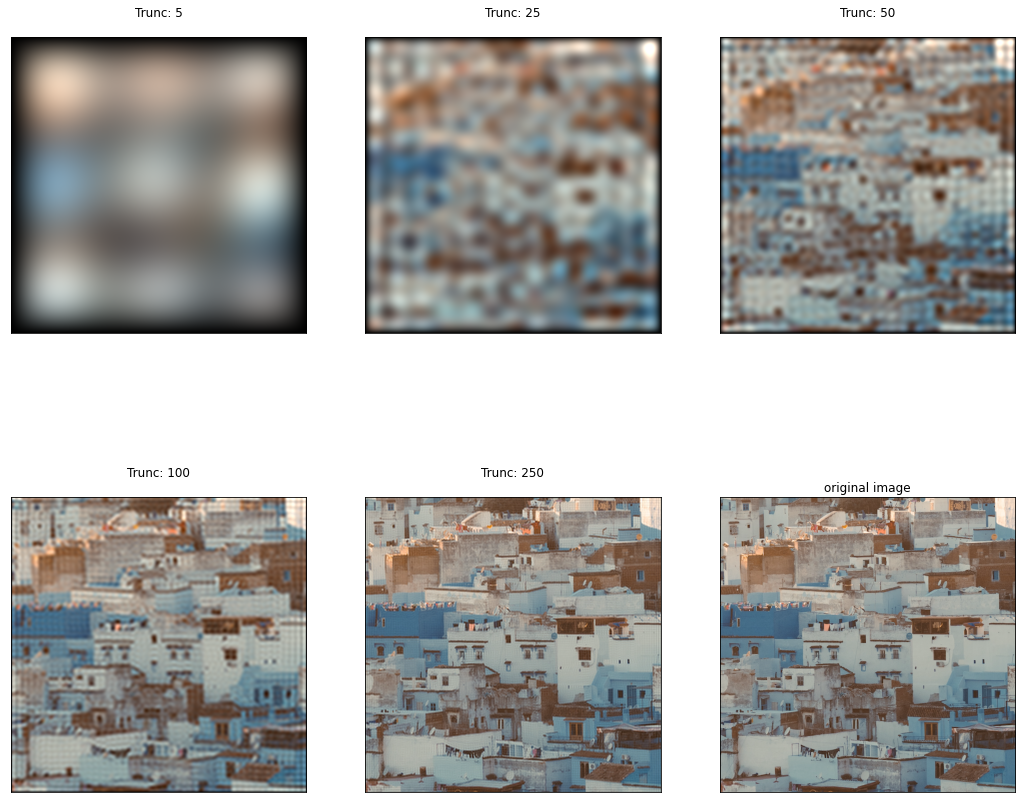

In [16]:
%%time

plot_image_channels(img)

## Image #2: 640_640_lizard.png

C:\Users\Darren\AppData\Local\Temp/ipykernel_9692/1191439235.py:3: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  img = imread(image_path)


original image: (640, 640, 3)
grayscaled image: (640, 640)


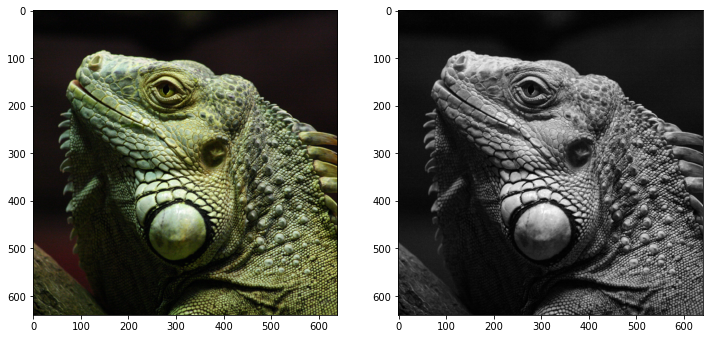

In [17]:
IMAGE_PATH = "https://raw.githubusercontent.com/dharmazz/SVD-Project/main/test_images/640_640_lizard.png"
img, img_gray = process_and_plot_image(IMAGE_PATH)

In [18]:
np.linalg.matrix_rank(img_gray)

640

In [19]:
%%time

max_norm=30
opt_rank_by_norm = img_func.get_optimal_rank(img_gray, by='norm', max_norm=max_norm)
print(f'optimum rank for frob_norm={max_norm} is {opt_rank_by_norm}')

optimum rank for frob_norm=30 is 88
Wall time: 462 ms


In [20]:
%%time

U, S, VT = img_func.numpy_svd(img_gray)
print(f'U: {U.shape}, S: {(S).shape}, VT: {VT.shape}')

U: (640, 640), S: (640, 640), VT: (640, 640)
Wall time: 192 ms


In [21]:
# Calculate Relative Error
Ub, Sb, VTb = img_func.phase_B_svd(img_gray)
Ua, Sa, VTa = img_func.phase_A_svd(img_gray)
Un, Sn, VTn = img_func.numpy_svd(img_gray)
print("Relative error of Phase A as compare to numpy's: ", img_func.relative_error(Sn,Sa))
print("Relative error of Phase B as compare to numpy's: ", img_func.relative_error(Sn,Sb))

Total Iterations: 655
Total Iterations: 1317
Relative error of Phase A as compare to numpy's:  4.142824213373056e-15
Relative error of Phase B as compare to numpy's:  0.00011745069328747145


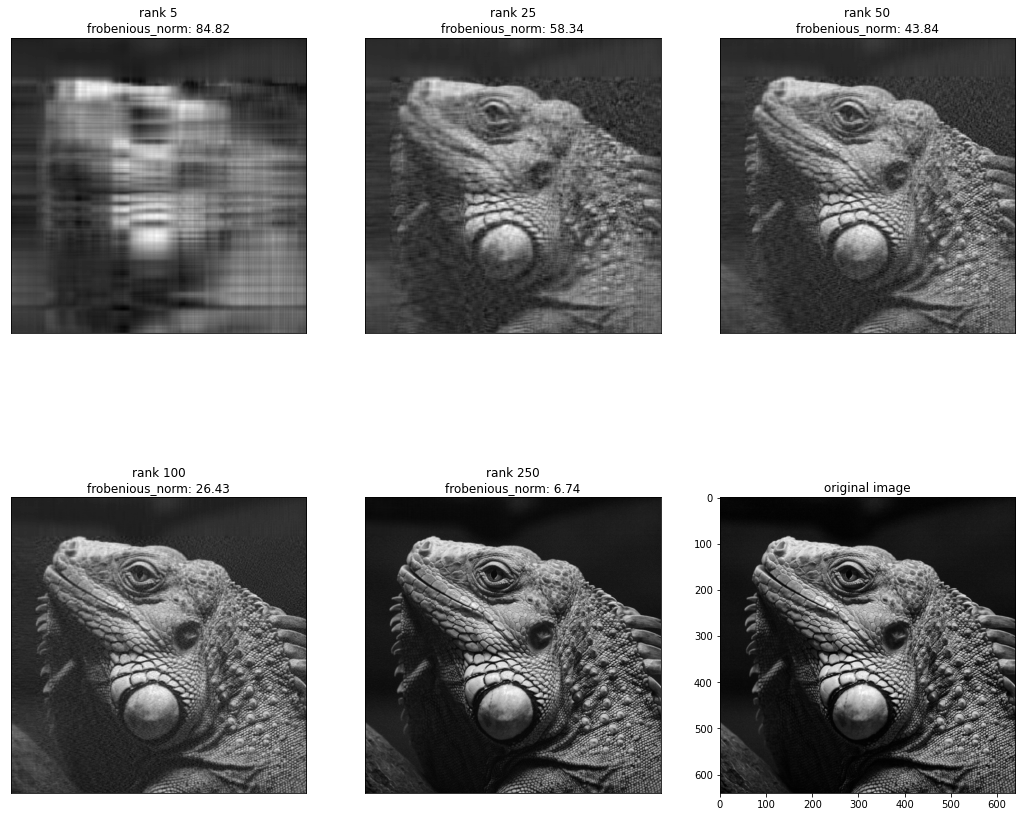

Wall time: 840 ms


In [22]:
%%time

plot_grayscale_images(U, S, VT, img_gray)

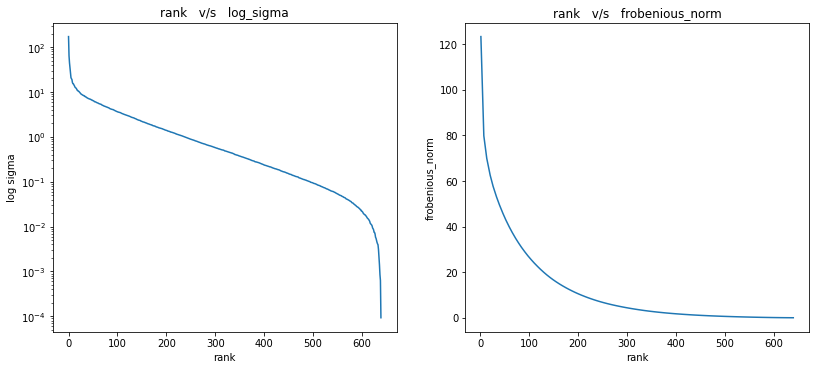

Wall time: 1.31 s


In [23]:
%%time

plot_rank_v_sigma_and_frobenious_norm(U, S, VT, img_gray)

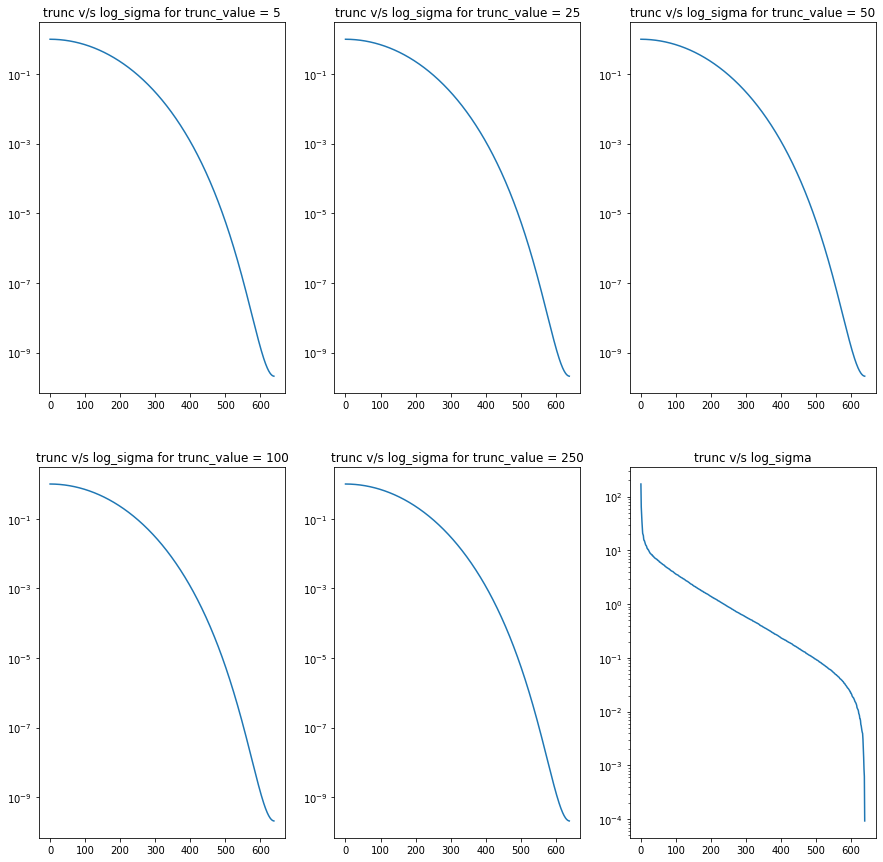

Wall time: 5.04 s


In [24]:
%%time

plot_truncate_svd(img_gray, S)

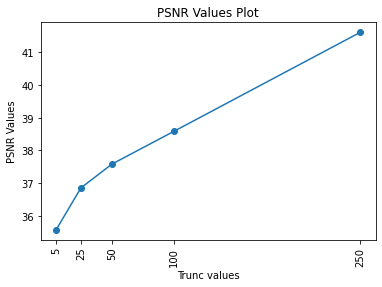

Wall time: 4.06 s


In [25]:
%%time

plot_psnr_values(img_gray)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Wall time: 29.4 s


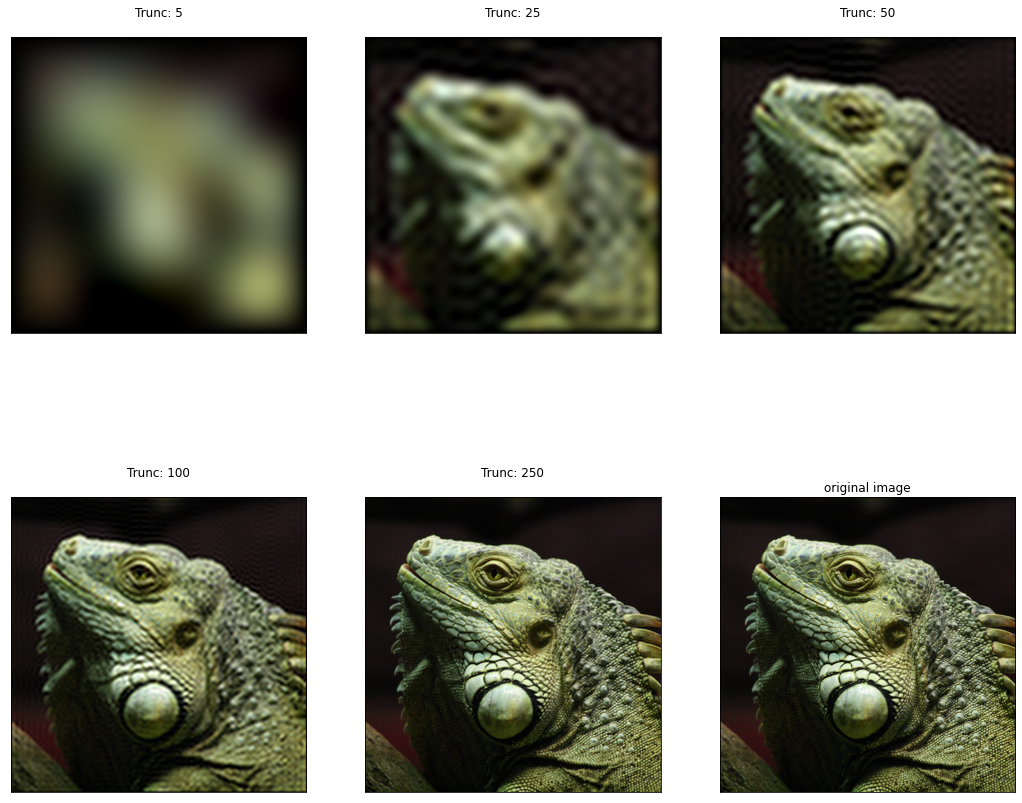

In [26]:
%%time

plot_image_channels(img)

## Image #3: 1024_1024_grassfield.png

C:\Users\Darren\AppData\Local\Temp/ipykernel_9692/2712941171.py:4: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  img = imread(image_path)


original image: (1024, 1024, 4)
grayscaled image: (1024, 1024)


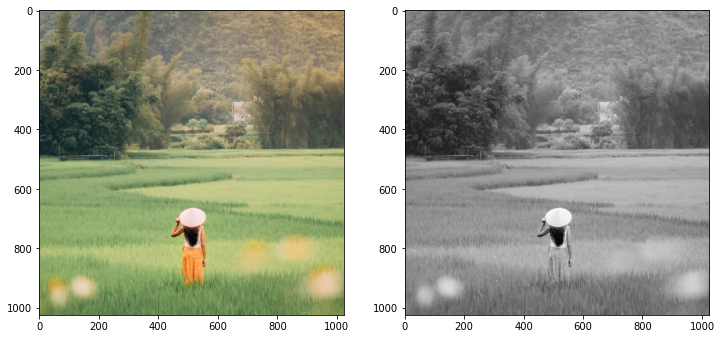

In [35]:
IMAGE_PATH = "https://raw.githubusercontent.com/dharmazz/SVD-Project/main/test_images/1024_1024_grassfield.png"
img, img_gray = process_and_plot_image(IMAGE_PATH)

In [36]:
np.linalg.matrix_rank(img_gray)

1024

In [37]:
%%time

max_norm=30
opt_rank_by_norm = img_func.get_optimal_rank(img_gray, by='norm', max_norm=max_norm)
print(f'optimum rank for frob_norm={max_norm} is {opt_rank_by_norm}')

optimum rank for frob_norm=30 is 12
Wall time: 841 ms


In [38]:
%%time

U, S, VT = img_func.numpy_svd(img_gray)
print(f'U: {U.shape}, S: {(S).shape}, VT: {VT.shape}')

U: (1024, 1024), S: (1024, 1024), VT: (1024, 1024)
Wall time: 665 ms


In [39]:
# Calculate Relative Error
Ub, Sb, VTb = img_func.phase_B_svd(img_gray)
Ua, Sa, VTa = img_func.phase_A_svd(img_gray)
Un, Sn, VTn = img_func.numpy_svd(img_gray)
print("Relative error of Phase A as compare to numpy's: ", img_func.relative_error(Sn,Sa))
print("Relative error of Phase B as compare to numpy's: ", img_func.relative_error(Sn,Sb))

Total Iterations: 1030
Total Iterations: 2084
Relative error of Phase A as compare to numpy's:  2.882493158114282e-14
Relative error of Phase B as compare to numpy's:  3.517803233498106e-05


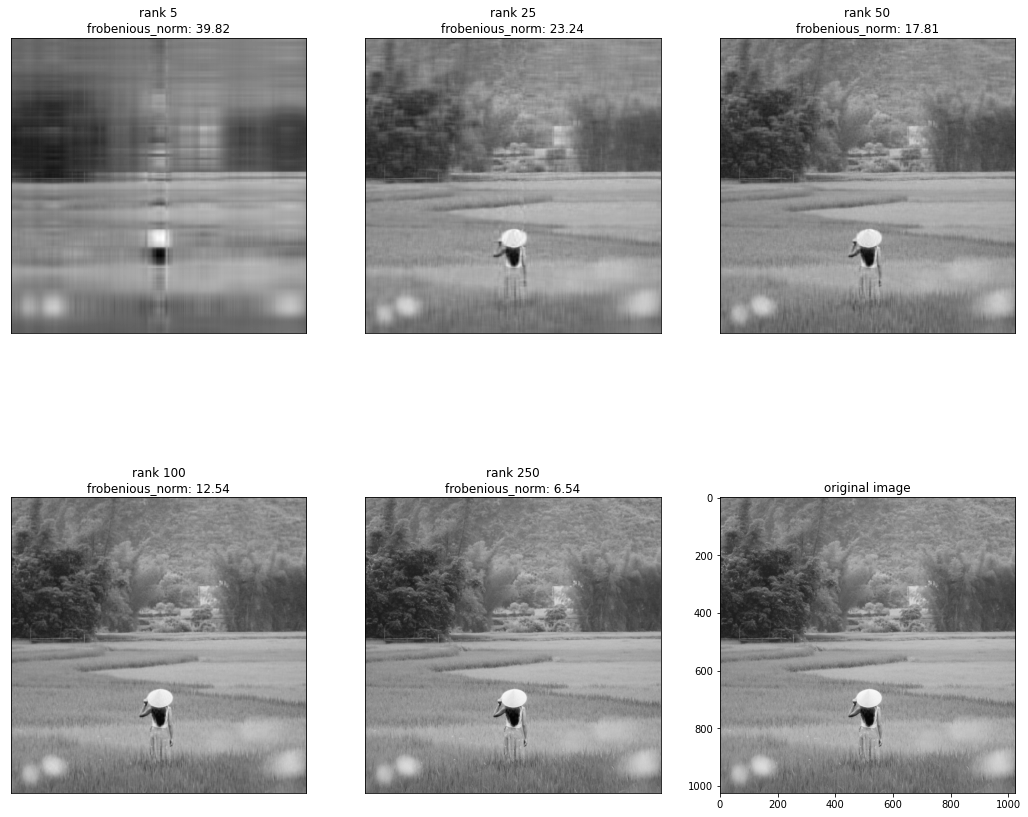

Wall time: 2.1 s


In [40]:
%%time

plot_grayscale_images(U, S, VT, img_gray)

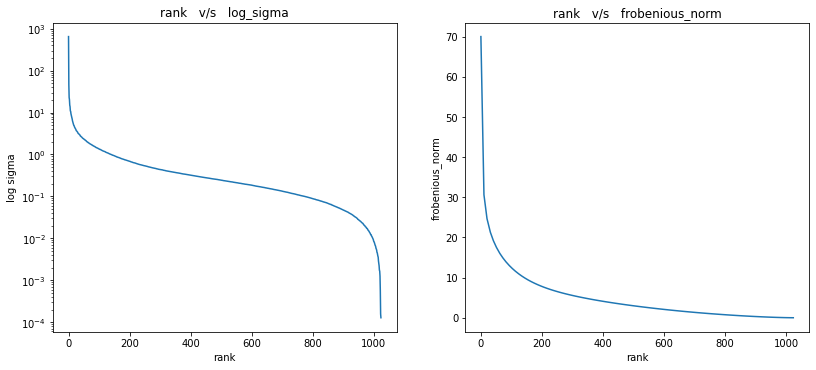

Wall time: 4.45 s


In [41]:
%%time

plot_rank_v_sigma_and_frobenious_norm(U, S, VT, img_gray)

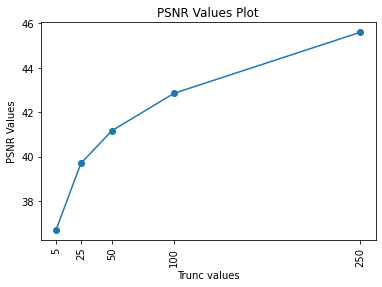

Wall time: 16.2 s


In [42]:
%%time

plot_psnr_values(img_gray)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Wall time: 2min 47s


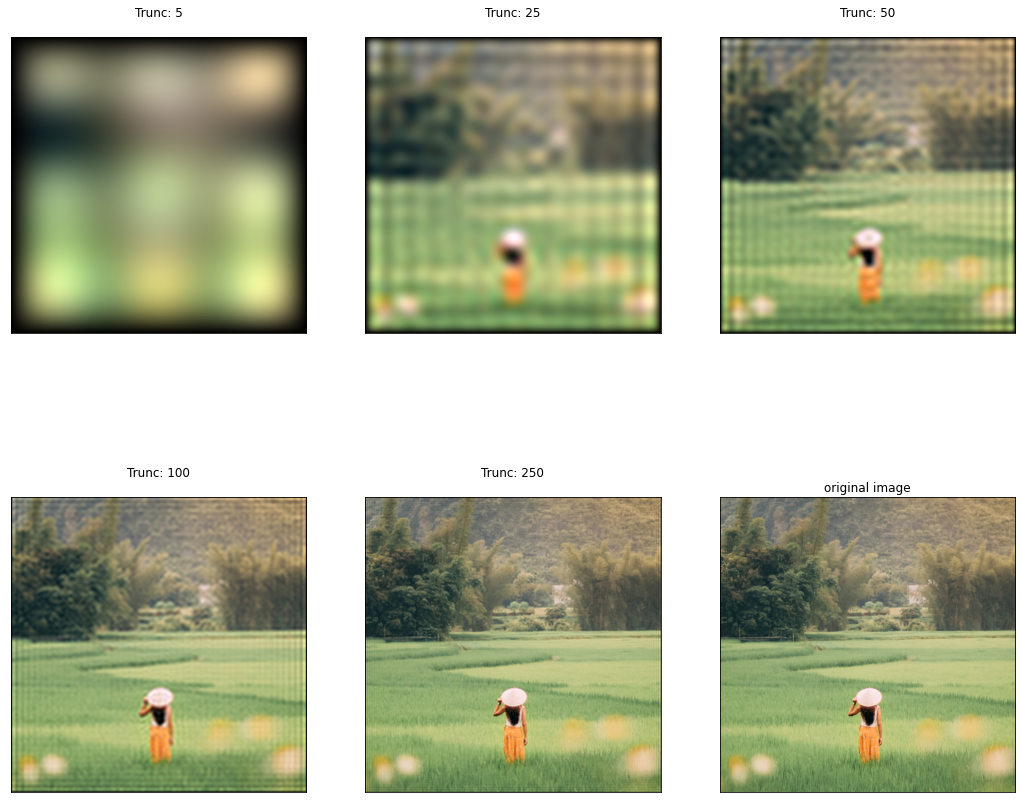

In [43]:
%%time

plot_image_channels(img)

# Video Background Extraction